-----
# **[RNN과 LSTM을 활용한 로이터 뉴스 분류]**
-----

In [1]:
# 각종 라이브러리 가져오기 
import tensorflow as tf

from tensorflow.keras.models import Sequential             
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional #양방향,문자열(장기기억)

from tensorflow.keras.datasets.reuters import load_data    
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from  tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split 

In [2]:
# 난수 생성 시의 시드 값 설정
seed = 0
np.random.seed(seed)

# 1. 데이터 수집


## 1.1 데이터 적재(load)

In [3]:
(훈련용_X, 훈련용_y), (테스트용_X, 테스트용_y) = load_data(num_words=100000, test_split=0.2)
# 1~100000에 해당하는 단어만 추출, 전체 뉴스 기사에서 20%만 테스트용으로 사용
#훈련용 뉴스기사 : 8982
# 테스트용 : 2246

2110848/2110848 [==============================] - 0s 0us/step


In [4]:
pd.DataFrame(훈련용_X) 

,0
0,"[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, ..."
1,"[1, 3267, 699, 3434, 2295, 56, 16784, 7511, 9,..."
2,"[1, 53, 12, 284, 15, 14, 272, 26, 53, 959, 32,..."
3,"[1, 4, 686, 867, 558, 4, 37, 38, 309, 2276, 46..."
4,"[1, 8295, 111, 8, 25, 166, 40, 638, 10, 436, 2..."
...,...
8977,"[1, 313, 262, 2529, 1426, 8, 130, 40, 129, 363..."
8978,"[1, 4, 96, 5, 340, 3976, 23, 328, 6, 154, 7, 4..."
8979,"[1, 141, 3890, 387, 81, 8, 16, 1629, 10, 340, ..."
8980,"[1, 53, 46, 957, 26, 14, 74, 132, 26, 39, 46, ..."


In [5]:
print(훈련용_X[0]) # 훈련용 뉴스기사중 첫번째 뉴스기사 ( 각단어가 정수로 변환된 상태)정수 인코딩한 상태

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [6]:
pd.DataFrame(훈련용_y)

,0
0,3
1,4
2,3
3,4
4,4
...,...
8977,19
8978,19
8979,25
8980,3


In [9]:
print(훈련용_y[0]) # 훈련용 뉴스기사중 첫번째 뉴스기사의 라벨(카테고리)
print(len(set(훈련용_y))) # 카테고리 개수

3
46


## 1.2 데이터 분할

In [11]:
훈련용_분할_X, 검증용_분할_X, 훈련용_분할_y, 검증용_분할_y = train_test_split(훈련용_X, 훈련용_y, train_size=0.8, test_size = 0.2, shuffle=True)

# 2. 데이터 탐색=탐색적 데이터 분석(EDA)

## 2.1 집합 크기 확인

In [12]:
# 각 데이터 집합(data sets)의 모양을 확인해 보겠습니다.
print(f'훈련용으로 분할한 X항의 모양 = {훈련용_분할_X.shape}')
print(f'검증용으로 분할한 X항의 모양 = {검증용_분할_X.shape}')
print(f'테스트용 X항의 모양 = {테스트용_X.shape}')
print('\n')
print(f'훈련용으로 분할한 y항의 모양 = {훈련용_분할_y.shape}')
print(f'검증용으로 분할한 y항의 모양 = {검증용_분할_y.shape}')
print(f'테스트용 y항의 모양 = {테스트용_y.shape}')

훈련용으로 분할한 X항의 모양 = (7185,)
검증용으로 분할한 X항의 모양 = (1797,)
테스트용 X항의 모양 = (2246,)


훈련용으로 분할한 y항의 모양 = (7185,)
검증용으로 분할한 y항의 모양 = (1797,)
테스트용 y항의 모양 = (2246,)


## 2.2 데이터 내용 확인


In [13]:
# 뉴스 기사가 들어 있는 X항의 구조
pd.DataFrame(훈련용_분할_X)

,0
0,"[1, 431, 484, 884, 568, 1184, 4, 37, 38, 66, 2..."
1,"[1, 232, 5002, 9, 873, 81, 8, 16, 701, 10, 133..."
2,"[1, 4652, 7665, 5322, 985, 5, 4, 237, 2813, 7,..."
3,"[1, 4, 60, 5, 794, 8, 16, 299, 45, 2112, 7, 4,..."
4,"[1, 16032, 17369, 149, 8, 261, 1533, 10, 384, ..."
...,...
7180,"[1, 4916, 11714, 81, 8, 16, 40, 515, 4, 384, 2..."
7181,"[1, 130, 23, 2916, 16002, 7951, 931, 43, 4, 37..."
7182,"[1, 27681, 81, 8, 16, 701, 42, 120, 6, 721, 10..."
7183,"[1, 4, 740, 291, 1098, 1641, 40, 1533, 42, 549..."


In [14]:
print(훈련용_분할_X[0])
print(훈련용_분할_X[1])
print(훈련용_분할_X[2])
print(훈련용_분할_X[3])

[1, 431, 484, 884, 568, 1184, 4, 37, 38, 66, 253, 41, 433, 102, 119, 35, 15, 52, 29, 290, 36, 3400, 1608, 62, 325, 10618, 21, 269, 10, 433, 115, 609, 115, 55, 1077, 6, 601, 756, 36, 118, 4, 424, 4008, 415, 16, 40, 2259, 6, 320, 410, 51, 115, 949, 601, 16, 1077, 6, 761, 233, 836, 36, 118, 4, 2749, 17, 12]
[1, 232, 5002, 9, 873, 81, 8, 16, 701, 10, 1331, 120, 6, 337, 25, 4901, 707, 13, 3920, 11, 15, 6, 884, 20376, 25071, 111, 10, 304, 5, 234, 3154, 71, 56, 9103, 4, 211, 5, 4, 4901, 707, 34, 170, 136, 4, 326, 384, 292, 300, 6, 337, 25, 4901, 9, 7920, 971, 16, 8, 4, 5357, 218, 34, 385, 54, 139, 13, 2611, 11, 15, 6, 8355, 71, 359, 5, 4968, 3591, 450, 232, 5002, 8, 4, 406, 96, 33, 30, 600, 7, 197, 10, 232, 5002, 1658, 8, 4, 211, 3092, 232, 6, 2137, 21, 25, 2292, 971, 1727, 9, 4752, 667, 1154, 22, 4, 211, 33, 30, 529, 6, 2932, 222, 9, 13, 100, 1120, 1619, 4, 49, 8, 7, 10, 1952, 241, 234, 3154, 8, 4, 211, 41, 30, 13, 3920, 11, 15, 962, 4, 3108, 5, 1786, 4, 211, 41, 30, 527, 6, 4048, 31, 4, 659

In [15]:
# 범주가 들어 있는 y항의 구조
pd.DataFrame(훈련용_분할_y)

,0
0,11
1,4
2,11
3,19
4,3
...,...
7180,4
7181,19
7182,3
7183,4


In [16]:
print(훈련용_분할_y)
print(검증용_분할_y)
print(테스트용_y)

[11  4 11 ...  3  4  3]
[20 19 28 ...  3  3 19]
[ 3 10  1 ...  3  3 24]


# 3. 데이터 가공


## 3.1 시퀀스(문장) 길이 통일하기
= 시퀀스 채우기
= 시퀀스 패딩(sequence padding)

In [17]:
# 길이를 맞추기 전의 각 X 항의 내용
print(len(훈련용_분할_X[0]))
print(len(훈련용_분할_X[1]))
print(len(훈련용_분할_X[2]))

66
197
264


이 출력 내용을 통해서 각 기사의 길이가 저마다 다르다는 점을 알 수 있습니다. 

In [20]:

훈련용_분할_X = pad_sequences(훈련용_분할_X, maxlen=200) 
검증용_분할_X = pad_sequences(검증용_분할_X, maxlen=200)
테스트용_X = pad_sequences(테스트용_X, maxlen=200)
print(len(훈련용_분할_X[0]) , len(검증용_분할_X[0]) , len(테스트용_X[0]))

200 200 200


In [15]:
# 길이를 맞춘 후의 각 X 항의 내용
pd.DataFrame(훈련용_분할_X)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0,0,0,0,0,0,0,0,0,0,...,6,761,233,836,36,118,4,2749,17,12
1,0,0,0,1,232,5002,9,873,81,8,...,10873,22142,26572,9,21504,3126,342,20112,17,12
2,477,1258,50,36,1457,5,7,10,765,6,...,13731,7,68,520,13,7627,7,395,17,12
3,0,0,0,0,0,0,0,0,0,0,...,76,6,1663,11,167,22,628,11,17,12
4,0,0,0,0,0,0,0,0,0,0,...,503,21,93,12,527,6,1135,2102,17,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7180,0,0,0,0,0,0,0,0,0,0,...,197,9,975,7,1609,5,2463,347,17,12
7181,1556,1086,125,174,4726,6,1102,4,66,911,...,1429,6,2897,4,223,4,3787,8,17,12
7182,0,0,0,0,0,0,0,0,0,0,...,11,15,13,4,188,943,1738,1831,17,12
7183,0,0,0,0,0,0,0,0,0,0,...,254,198,51,45,565,97,397,124,17,12


In [16]:
pd.DataFrame(검증용_분할_X)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0,0,0,0,0,0,0,0,0,0,...,58,193,26,10,67,10,29,157,17,12
1,34,328,51,1896,8,36,114,45,452,5669,...,7,576,31,4,521,562,36,152,17,12
2,0,0,0,0,0,0,0,0,0,0,...,935,107,77,64,4,2267,1156,8,17,12
3,0,0,0,0,0,0,0,0,0,0,...,136,78,11,15,90,29,16,8,17,12
4,0,0,0,0,0,0,0,0,0,0,...,107,37,38,2928,37,38,973,8,17,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,0,0,0,0,0,0,0,0,0,0,...,1889,4,1753,300,34,370,381,84,17,12
1793,0,0,0,0,0,0,0,0,0,0,...,266,481,159,9,186,13,4,49,17,12
1794,0,0,0,0,0,0,0,0,0,0,...,5603,123,382,685,1312,5999,1088,149,17,12
1795,0,0,0,0,0,0,0,0,0,0,...,4,3497,120,6,246,4,1222,347,17,12


In [17]:
pd.DataFrame(테스트용_X)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0,0,0,0,0,0,0,0,0,0,...,324,27,56,23406,28185,5,192,510,17,12
1,4,96,1043,1569,13,10,184,28,61,376,...,95,6,1732,1516,281,4,225,760,17,12
2,7,2775,33,30,1015,43,33,5602,50,489,...,9,115,949,343,756,2509,36,8,17,12
3,0,0,0,0,0,0,0,0,0,0,...,5,879,122,28,4,6452,3254,979,17,12
4,0,0,0,0,0,0,0,0,0,0,...,1099,871,6,10,4748,4,173,8,17,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2241,0,0,0,0,0,0,0,0,0,0,...,27,261,28,4,93,360,303,163,17,12
2242,0,0,0,0,0,0,0,0,0,0,...,5,32,445,18,15,22,2526,404,17,12
2243,0,0,0,0,0,0,0,0,0,0,...,11,430,3259,44,11,14,61,11,17,12
2244,0,0,0,0,0,0,0,0,0,0,...,1652,3603,6,4,166,4,49,8,17,12


## 3.2 표적치(범주)를 원핫인코딩

In [18]:
pd.DataFrame(훈련용_분할_y)

,0
0,11
1,4
2,11
3,19
4,3
...,...
7180,4
7181,19
7182,3
7183,4


In [21]:
훈련용_분할_원핫인코딩_y = to_categorical(훈련용_분할_y)
검증용_분할_원핫인코딩_y = to_categorical(검증용_분할_y)
테스트용_원핫인코딩_y = to_categorical(테스트용_y)

In [22]:
pd.DataFrame(훈련용_분할_원핫인코딩_y)

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7180,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7182,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7183,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 4. 모형 구성(모형 설계)

In [23]:
#csv로 구현하는것 추가해보기
callback = EarlyStopping(monitor='loss', patience=10)

## 4.2 모형 구조 설계

In [24]:

모형 = Sequential()                       

## 4.3 계층 구성

In [25]:
모형.add(Embedding(input_dim=100000, output_dim=4, input_length=200))  
# LSTM 계층을 두 번째 단에 두겠습니다.
모형.add(LSTM(200, activation='tanh', dropout=0.3))
# 모형.add(LSTM(200,  return_sequences=True))
# 모형.add(LSTM(200)
모형.add(Dense(46, activation='softmax'))
모형.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 4)            400000    
                                                                 
 lstm (LSTM)                 (None, 200)               164000    
                                                                 
 dense (Dense)               (None, 46)                9246      
                                                                 
Total params: 573,246
Trainable params: 573,246
Non-trainable params: 0
_________________________________________________________________


# 5. 모형 컴파일

In [24]:
모형.compile(loss='categorical_crossentropy', 
              optimizer='adam',               
              metrics=['accuracy'])           

# 6. 모형 훈련

In [25]:
훈련_이력 = 모형.fit(훈련용_분할_X, 훈련용_분할_원핫인코딩_y, 
                      batch_size=200, 
                      epochs=50, 
                      validation_data=(검증용_분할_X, 검증용_분할_원핫인코딩_y),
                      verbose=1)

Epoch 1/50
36/36 [==============================] - 18s 440ms/step - loss: 2.7457 - accuracy: 0.3207 - val_loss: 2.4033 - val_accuracy: 0.3628
Epoch 2/50
36/36 [==============================] - 17s 462ms/step - loss: 2.4140 - accuracy: 0.3489 - val_loss: 2.3949 - val_accuracy: 0.3628
Epoch 3/50
36/36 [==============================] - 17s 468ms/step - loss: 2.4110 - accuracy: 0.3489 - val_loss: 2.3928 - val_accuracy: 0.3628
Epoch 4/50
36/36 [==============================] - 17s 475ms/step - loss: 2.4011 - accuracy: 0.3489 - val_loss: 2.3633 - val_accuracy: 0.3628
Epoch 5/50
36/36 [==============================] - 18s 490ms/step - loss: 2.2205 - accuracy: 0.4281 - val_loss: 2.0458 - val_accuracy: 0.4925
Epoch 6/50
36/36 [==============================] - 18s 490ms/step - loss: 2.0187 - accuracy: 0.4761 - val_loss: 1.9447 - val_accuracy: 0.4880
Epoch 7/50
36/36 [==============================] - 21s 576ms/step - loss: 1.9195 - accuracy: 0.4900 - val_loss: 1.9113 - val_accuracy: 0.4981

# 7. 모형 훈련 평가





In [26]:
훈련용_데이터_손실 = 훈련_이력.history['loss'] 
훈련용_데이터_정확도 = 훈련_이력.history['accuracy'] 

검증용_데이터_손실 = 훈련_이력.history['val_loss']
검증용_데이터_정확도 = 훈련_이력.history['val_accuracy']

In [27]:
type(훈련용_데이터_손실)

list

In [28]:
훈련용_데이터_손실

[2.745741367340088,
 2.4140310287475586,
 2.4109506607055664,
 2.401118278503418,
 2.220459461212158,
 2.018720865249634,
 1.9194964170455933,
 1.819138765335083,
 1.7351913452148438,
 1.716233730316162,
 1.8630752563476562,
 1.6995991468429565,
 1.6412872076034546,
 2.4247629642486572,
 2.0241525173187256,
 2.261507749557495,
 1.887807846069336,
 1.75590181350708,
 1.6636133193969727,
 1.629132628440857,
 1.5741733312606812,
 1.5477361679077148,
 1.509011149406433,
 1.4864860773086548,
 1.449541449546814,
 1.4255057573318481,
 1.4239132404327393,
 1.4177075624465942,
 1.374715805053711,
 1.341965913772583,
 1.2996108531951904,
 1.2994353771209717,
 1.2629740238189697,
 1.2544573545455933,
 1.2067526578903198,
 1.1916711330413818,
 1.15293550491333,
 1.150819182395935,
 1.1229034662246704,
 1.1102054119110107,
 1.112093210220337,
 1.0957189798355103,
 1.07184636592865,
 1.058057188987732,
 1.0281212329864502,
 1.0174437761306763,
 1.0037853717803955,
 0.9812949299812317,
 0.98722529411

In [29]:
# X 축의 길이를 정합니다. 
x_len = np.arange(len(훈련용_데이터_정확도))
x_len


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

Text(0, 0.5, 'pred_value')

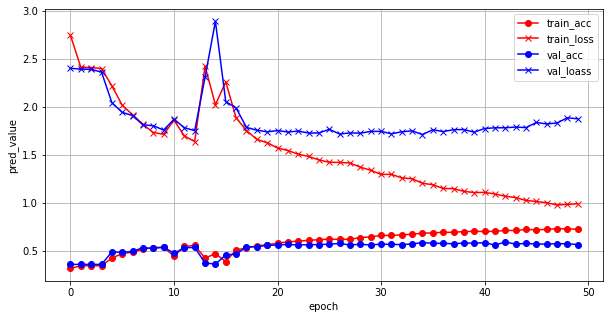

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(x_len, 훈련용_데이터_정확도, marker='o', c="r", label='train_acc');
plt.plot(x_len, 훈련용_데이터_손실, marker='x', c="r", label='train_loss');

plt.plot(x_len, 검증용_데이터_정확도, marker='o', c="b", label='val_acc');
plt.plot(x_len, 검증용_데이터_손실, marker='x', c="b", label='val_loass');

# 그 밖의 그래프에 필요한 요소들을 추가합니다. 
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('pred_value')


# 8. 모형 성능 평가

In [31]:
손실, 정확도 = 모형.evaluate(테스트용_X, 테스트용_원핫인코딩_y)

print('\n')
print(f"손실: {손실: .4f}, 정확도: {정확도 * 100: 2.2f}%")

71/71 [==============================] - 4s 56ms/step - loss: 1.8790 - accuracy: 0.5721


손실:  1.8790, 정확도:  57.21%


# 9. 모형 활용(=추론 = 예측)

In [32]:
예측치 = 모형.predict(테스트용_X)

71/71 [==============================] - 4s 52ms/step


In [33]:
pd.DataFrame(예측치) 

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,0.000161,0.004862,0.000210,0.014007,0.890565,0.000070,0.001376,0.001660,0.004538,0.000361,...,0.001742,0.000183,0.000328,0.003296,0.000125,0.000523,0.000138,0.000104,0.000085,0.000083
1,0.019905,0.167343,0.114342,0.003241,0.006423,0.023775,0.004828,0.000153,0.000270,0.227443,...,0.002671,0.002283,0.037811,0.000111,0.007973,0.000153,0.000283,0.001118,0.013252,0.008336
2,0.003588,0.006774,0.015774,0.001494,0.003288,0.001055,0.002736,0.000060,0.000268,0.030276,...,0.004634,0.002648,0.002556,0.000016,0.090726,0.000056,0.000471,0.001639,0.002266,0.014145
3,0.000022,0.000952,0.000024,0.021808,0.968992,0.000007,0.000027,0.000130,0.000387,0.000061,...,0.000352,0.000007,0.000050,0.000173,0.000011,0.000033,0.000006,0.000007,0.000014,0.000003
4,0.000116,0.000687,0.000146,0.000174,0.000244,0.000046,0.003938,0.000100,0.005054,0.000307,...,0.001494,0.007662,0.000049,0.000055,0.000678,0.000454,0.004054,0.001346,0.000042,0.001290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2241,0.000102,0.004124,0.000134,0.497008,0.464152,0.000035,0.000057,0.000429,0.001548,0.000591,...,0.001525,0.000036,0.000580,0.000661,0.000072,0.000125,0.000022,0.000053,0.000083,0.000021
2242,0.000031,0.001831,0.000050,0.968932,0.010510,0.000009,0.000008,0.000084,0.000646,0.000444,...,0.000773,0.000016,0.000793,0.000145,0.000021,0.000036,0.000005,0.000021,0.000065,0.000007
2243,0.000022,0.001309,0.000033,0.977790,0.007125,0.000006,0.000004,0.000053,0.000383,0.000325,...,0.000594,0.000010,0.000586,0.000092,0.000013,0.000023,0.000003,0.000013,0.000047,0.000004
2244,0.000017,0.000655,0.000021,0.003802,0.990179,0.000008,0.000057,0.000104,0.000302,0.000039,...,0.000161,0.000007,0.000029,0.000162,0.000010,0.000028,0.000006,0.000005,0.000008,0.000004


In [34]:
예측치 = 모형.predict(테스트용_X[:40])
print([np.argmax(예측치[i]) for i in range(40)])

2/2 [==============================] - 0s 30ms/step
[4, 9, 19, 4, 13, 3, 3, 3, 3, 4, 1, 4, 1, 3, 11, 8, 4, 3, 19, 3, 8, 3, 3, 4, 9, 3, 4, 20, 1, 3, 3, 1, 4, 3, 19, 4, 20, 1, 1, 3]


In [35]:
print([np.argmax(테스트용_원핫인코딩_y[i]) for i in range(40)])

[3, 10, 1, 4, 4, 3, 3, 3, 3, 3, 5, 4, 1, 3, 1, 11, 23, 3, 19, 3, 8, 3, 3, 3, 9, 3, 4, 6, 10, 3, 3, 10, 20, 1, 19, 4, 40, 1, 4, 3]
